<a href="https://colab.research.google.com/github/Ibrahim-giti/Simple-open-vocabulary-object-detector/blob/main/Simple_open_vocab_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This takes input from the user, takes out the nouns and uses that as queries for the OWL-VIT

In [155]:
import spacy

# Load spaCy model (en_core_web_sm for English)
nlp = spacy.load('en_core_web_sm')

# Input text
text = input("write what you want: ")

#sample text
#text_queries = ["table"]


# Process the text
doc = nlp(text)

# # Extract relevant nouns
text_queries = [token.text for token in doc if token.pos_ in ["NOUN"]]

print("Relevant words for detection:", text_queries)



write what you want: please fetch me popcorn on the table
Relevant words for detection: ['popcorn', 'table']


### Import all the necessary libraries

In [156]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection
from PIL import Image
import cv2
import numpy as np
import torch
from skimage import data

## Load the model

In [157]:
# Use GPU if available
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32").to(device)
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")  #preprocesses image



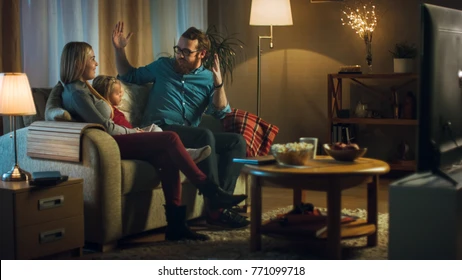

In [158]:
image_path = "living_room.png"

image = Image.open(image_path)
image


##Load the image and the input text to the OWL-VIT

In [159]:
# Preprocess the inputs (image and text)

#inputs = processor(text=relevant_words, images=image, return_tensors="pt")
inputs = processor(text=text_queries, images=image, return_tensors="pt")


with torch.no_grad():
    outputs = model(**inputs)

# Post-process the results to get predictions (boxes, scores, labels)
target_sizes = torch.tensor([image.size[::-1]])  # Need target size for post-processing
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes)

# Extract boxes, scores, and labels
boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

# Print the results
print("Boxes:", boxes)
print("Scores:", scores)
print("Labels:", labels)


Boxes: tensor([[239.5268, 143.6106, 395.1917, 255.7758]])
Scores: tensor([0.1716])
Labels: tensor([1])


In [160]:
THRESHOLD = 0.1 # defines the minimum confidence a detection must have

target_sizes = torch.Tensor([image.size[::-1]])
target_sizes = target_sizes.to(device)

# convert output into readable results
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=THRESHOLD)
boxes, scores, labels = results[0]["boxes"], results[0]["scores"], results[0]["labels"]

for box, score, label in zip(boxes, scores, labels):
  print("=======================")
  print(box) # coordinates of bounding box around detected object
  print(text_queries[label]) # label is the index of the string object array
  print(score) # confidence of model
  print("=======================\n")

tensor([239.5268, 143.6106, 395.1917, 255.7758])
table
tensor(0.1716)



## Plot the bounding box on the original image

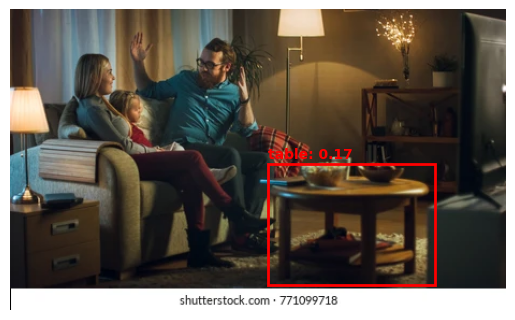

In [154]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Display the image with bounding boxes using Matplotlib
def plot_image_with_boxes(image, boxes, labels, scores, texts):
    fig, ax = plt.subplots(1)
    ax.imshow(image)  # Show the image

    # Loop over the bounding boxes, labels, and scores
    for box, label, score in zip(boxes, labels, scores):
        # Unpack the box coordinates
        xmin, ymin, xmax, ymax = box

        # Create a rectangle patch for the bounding box
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')

        # Add the bounding box to the plot
        ax.add_patch(rect)

        # Add the label text with score above the bounding box
        ax.text(xmin, ymin - 5, f'{texts[label]}: {score:.2f}', color='red', fontsize=10, weight='bold')

    # Display the image with bounding boxes
    plt.axis("off")  # Hide axis
    plt.show()

# Convert the image back from tensor to numpy for plotting (if needed)
image_np = np.array(image)

# Plot the image with bounding boxes
#plot_image_with_boxes(image_np, boxes, labels, scores, relevant_words)
plot_image_with_boxes(image_np, boxes, labels, scores, text_queries)